# Solar sail (maximum orbit change)

Maximize the dispacement of the solar sail in the tangent manifold of its orbital elements over one orbit:

$$ \delta I' = \mathbf{G}(I,M) \, u,\quad u(M) \in U, $$

$$ \delta I(0) = 0, \quad \delta I(2\pi) \parallel \mathbf{d}, $$

$$ \left( \delta I (2\pi) \, | \, \mathbf{d} \right) \longrightarrow \max. $$

Fixed initial Keplerian orbit and direction of the displacement $\mathbf{d}$. 

[Thumbnail](solarsail.jpg)

## Initializations

In [1]:
import numpy as np
import scipy
import os
from scipy.integrate import ode
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
from mpl_toolkits.mplot3d import Axes3D
import time
from nutopy import nle
from nutopy import tools
from nutopy import ocp
from nutopy import path
from scipy.linalg import null_space
from gve import *
from gvef import *
from os import system

# Definition of optical parameters 
rho     = 0.88         # Specular reflection coefficient
a       = 1. - rho    # Absorption coefficient
s       = 0.94        # Diffuse reflection coefficient 
eps_f   = 0.05        # Emissivity front coeff 0.05
eps_b   = 0.55        # Emissivity back coeff 0.55
Bf      = 0.79        # Front Lambertian coeff 0.79
Bb      = 0.55        # Back Lambertian coeff 0.55
eps     = (Bf * eps_f - Bb * eps_b) / (eps_b + eps_f) 
#opt_p   = np.array([rho, s, eps_f, eps_b, Bf, Bb, eps])
b       = np.array([1. - rho * s, 2. * rho * s, Bf * rho * (1. - s) + (1. - rho) * eps ])

# Parameters of the problem
cont    = 0.    # 0 for triangular cone, 1 for real drop 
mu      = 1.


def deg2rad(x):
    y = x * np.pi / 180.
    return y

def rad2deg(x):
    y = x * 180. / np.pi
    return y

# CASE WITH STRUCTURE CHANGE

I            = np.array([deg2rad(10), deg2rad(50), deg2rad(30), 1, 0.1]) 
pdeltaI           = np.array([ -0.0837,    1.0000,   -0.0052,    0.0398,    0.0852 ])
M1_guess     = 0.7086
M2_guess     = 4.3302
M3_guess     = 4.7962
M4_guess     = 5.2500
deltaI1_guess     = np.array([ -0.0013,   -0.0002,    0.0251,    0.0027,    0.0012])
deltaI2_guess     = np.array([ 0.0136,    0.4053,   -0.3069,    0.0473,   0.0656])
deltaI3_guess     = np.array([ 0.0148,    0.4054,   -0.3289,    0.0498,    0.0626])
deltaI4_guess     = np.array([ 0.0000,    0.4134,   -0.0002,    0.0001,    0.0000])
d            = np.array([ 0.,  1.,  0.,  0.,  0.]) 


z          = np.hstack((pdeltaI, M1_guess, M2_guess, M3_guess, M4_guess, deltaI1_guess, deltaI2_guess, deltaI3_guess, deltaI4_guess))


z_auto     = np.hstack((pdeltaI))
sDir       = np.array([0., 0., -1.])


# Initial state

I0      = np.array([0., 0., 0., 0., 0]) # delta I (0)
M0      = 0
Mf      = 2*np.pi

# Real cone force definition
cBeta   = (- b[0] * b[2]  - 2. * b[1] * b[2] + \
             np.sqrt(b[0] ** 2 * b[2] ** 2 - 4. * b[0] * b[2] ** 2 * b[1] + 8. * b[0] ** 2 * b[1] ** 2 + 4. * b[1] ** 3 * b[0])) / \
             (4. * b[0] * b[1] + 2. * b[1] ** 2);
sBeta 	= np.sqrt(1 - cBeta ** 2);
fs    	= b[0] * cBeta + (b[1] * cBeta ** 2 + b[2] * cBeta) * cBeta;
fperp 	= (b[1] * cBeta ** 2 + b[2] * cBeta) * sBeta;
fCone 	= np.array([fs, fperp])


pars    = np.hstack((mu, I, fCone, b))

# Orthogonal vector family
d_orth  = scipy.linalg.null_space([d])                                                                     # Orthogonal space of b
d_orth  = d_orth.transpose()

In [2]:
#!pygmentize hfun.f90			

## Hamiltonian

In [3]:
def hamiltonian_implicit(compile=False, display=False):
    
    if display:
        out = ''
    else:
        out = ' > /dev/null 2>&1'
    
    if not compile:
        try:
            from hfunimplicit         import hfunimplicit        as hfun_u
            from hfunimplicit_di      import hfunimplicit_di     as dhfun_u
            from hfunimplicit_di_di   import hfunimplicit_di_di  as d2hfun_u
            from hfunalpha_da         import hfunalpha_da        as dhfunalpha 
            from hfunalpha_da_da      import hfunalpha_da_da     as d2hfunalpha
            import hfunalpha
            
        except ModuleNotFoundError:
            compile = True
        
    if compile:
        # Compiling hmin
        os.system('python -m numpy.f2py -c hfunimplicit.f90 hfunalpha.f90 hfunalpha_da_da.f90 hfuncone_dc.f90 hfunalpha_da.f90 -m hfunimplicit ' + out)
        os.system('python -m numpy.f2py -c hfunimplicit_di.f90     -m hfunimplicit_di    ' + out)
        os.system('python -m numpy.f2py -c hfunimplicit_di_di.f90 -m hfunimplicit_di_di ' + out)
        os.system('python -m numpy.f2py -c hfunalpha_da.f90 -m hfunalpha_da ' + out)
        os.system('python -m numpy.f2py -c hfunalpha_da_da.f90 hfunalpha_da.f90 -m hfunalpha_da_da ' + out)
        os.system('python -m numpy.f2py -c hfunalpha.f90 -m hfunalpha ' + out)
        
        from hfunimplicit             import hfunimplicit        as hfun_u
        from hfunimplicit_di          import hfunimplicit_di     as dhfun_u
        from hfunimplicit_di_di       import hfunimplicit_di_di  as d2hfun_u
        from hfunalpha_da             import hfunalpha_da        as dhfunalpha 
        from hfunalpha_da_da      import hfunalpha_da_da     as d2hfunalpha
        import hfunalpha
        
    ufun        = lambda M, deltaI, pdeltaI, alpha, cont : hfunalpha.control(M, deltaI, pdeltaI, alpha, pars, cont)
    pmpcone     = lambda pIG, sDir, fcone                                              : hfunalpha.pmpcone(pIG, sDir, fcone)
    gveeci      = lambda M, I, mu                                                      : hfunalpha.gveeci(M, I, mu)

    hfun_u      = tools.tensorize(dhfun_u, d2hfun_u, tvars=(1, 2, 3, 5), full=True)(hfun_u)
    ufun        = tools.vectorize(vvars=(1,2,3,4))(ufun)
    Hu          = ocp.Hamiltonian(hfun_u)
    
    return Hu, dhfunalpha, d2hfunalpha, ufun, gveeci, pmpcone

In [4]:
def dhfun_0(M, dM, deltaI, ddeltaI, pdeltaI, dpdeltaI, pars, cont, dcont):
    h   = 0.0
    dh  = 0.0
    return h, dh

def d2hfun_0(M, dM, d2M, deltaI, ddeltaI, d2deltaI, pdeltaI, dpdeltaI, d2pdeltaI, pars, cont, dcont, d2cont):
    h   = 0.0
    dh  = 0.0
    d2h = 0.0
    return h, dh, d2h

def hfun_0(M, deltaI, pdeltaI, pars, cont):
    h   = 0.0
    return h

In [5]:
hfun_0           = tools.tensorize(dhfun_0, d2hfun_0, tvars=(1, 2, 3, 5), full=True)(hfun_0)
[Hu, dhfunalpha, d2hfunalpha, ufun, gveeci, pmpcone] = hamiltonian_implicit(compile=True, display=False)
H0               = ocp.Hamiltonian(hfun_0)
fu               = ocp.Flow(Hu)
f0               = ocp.Flow(H0)



## Auxiliary function

In [6]:
def calculpIG(M, I, pdeltaI) :
    [fx, fy, fz] = gveeci(M, I, mu)
    pIG = np.array([0.0, 0.0, 0.0])
    pIG[0] = np.dot(fx[0:5],pdeltaI)
    pIG[1] = np.dot(fy[0:5],pdeltaI)
    pIG[2] = np.dot(fz[0:5],pdeltaI)
    return pIG

## Initials guess for alpha

In [7]:
def alphG1(alpha) : 
    ddeltaI = np.zeros(5)
    dpdeltaI = np.zeros(5)
    return dhfunalpha(M1_guess, 0., deltaI1_guess, ddeltaI, pdeltaI, dpdeltaI, alpha, 1.0, pars, cont)[1]

nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8) 
sol1 = nle.solve(alphG1, 1., options=nleopt); 
sol1x = sol1.x

while(sol1x < 2 * np.pi) :
    sol1x = sol1x + (2 * np.pi)

ddeltaI = np.zeros(5)
dpdeltaI = np.zeros(5)
print("Second derivative : ", d2hfunalpha(M1_guess, 0, deltaI1_guess, ddeltaI, pdeltaI, dpdeltaI, sol1x, 1.0, 1.0, pars, cont)[2])



     Calls  |f(x)|                 |x|
 
         1  1.005987478823275e-01  1.000000000000000e+00
         2  1.854665180937448e-02  1.189584936841644e+00
         3  6.788173443509904e-03  1.232437782535896e+00
         4  1.382103926697034e-03  1.257176744506096e+00
         5  1.681035509251971e-04  1.263501453497552e+00
         6  5.464276592842543e-06  1.264377240738851e+00
         7  2.314074426523760e-08  1.264406665019933e+00
         8  3.213720956019017e-12  1.264406790159202e+00
         9  4.163336342344337e-17  1.264406790176583e+00

 Results of the nle solver method:

 xsol    =  1.2644067901765834
 f(xsol) =  4.163336342344337e-17
 nfev    =  9
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.

Second derivative :  -0.18489413514335046


In [8]:
def alphG3(alpha) : 
    ddeltaI = np.zeros(5)
    dpdeltaI = np.zeros(5)
    return dhfunalpha(M3_guess, 0, deltaI3_guess, ddeltaI, pdeltaI, dpdeltaI, alpha, 1.0, pars, cont)[1]

nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8) 
sol3 = nle.solve(alphG3, 0.9, options=nleopt);
sol3x = sol3.x

print("Second derivative : ", d2hfunalpha(M3_guess, 0, deltaI3_guess, ddeltaI, pdeltaI, dpdeltaI, sol3x, 1.0, 1.0, pars, cont)[2])


     Calls  |f(x)|                 |x|
 
         1  4.546597145281600e-01  9.000000000000000e-01
         2  7.024476373541089e-02  1.173275278375973e+00
         3  2.746983974151956e-02  1.223211310584560e+00
         4  6.197995064495532e-03  1.255279977785304e+00
         5  9.543364764840745e-04  1.264623852002750e+00
         6  4.713837250303055e-05  1.266324420384104e+00
         7  3.983494158976697e-07  1.266412782590193e+00
         8  1.692288531529584e-10  1.266413535671404e+00
         9  5.551115123125783e-16  1.266413535991467e+00

 Results of the nle solver method:

 xsol    =  1.2664135359914674
 f(xsol) =  5.551115123125783e-16
 nfev    =  9
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.

Second derivative :  -0.5287328244689595


In [9]:
alpha1_guess   = sol1x 
alpha3_guess   = sol3x 

z = np.hstack((z, alpha1_guess, alpha3_guess))

## function that calculates the number of switche

In [10]:
## GEOMETRIC POLYNOMIAL calculates: v1^2 + v^2 - c^2 * v^3 (= 0?) 

def switch_pol_geom_gve(z, pars, f):
    #rho = opt_p[0]; s = opt_p[1]; eps_f = opt_p[2]; eps_b = opt_p[3]; Bf = opt_p[4]; Bb = opt_p[5]; eps = opt_p[6]
    Om = pars[1]; i = pars[2]; w = pars[3]; a = pars[4]; e = pars[5]
    pI = z[0 : 5]
    mu = pars[0]	
    
    # COMPUTATION OF ANGLE ALPHA
    alpha      = np.arctan2(fperp, fs)
    c          = np.tan(alpha + np.pi/2)
    cosf       = np.cos(f)    
    coef2      = (1. + e * cosf)**2

    OE         = np.array([Om, i, w, a, e, f])
    Fx, Fy, Fz = gveecif(OE, mu)
    v1         = pI[0] * Fx[0] +  pI[1] * Fx[1] + pI[2] * Fx[2] + pI[3] * Fx[3] + pI[4] * Fx[4]
    v2         = pI[0] * Fy[0] +  pI[1] * Fy[1] + pI[2] * Fy[2] + pI[3] * Fy[3] + pI[4] * Fy[4]
    v3         = pI[0] * Fz[0] +  pI[1] * Fz[1] + pI[2] * Fz[2] + pI[3] * Fz[3] + pI[4] * Fz[4]
    
    sol        = v1 ** 2 * coef2 + v2**2 * coef2 - c**2 * v3**2 * coef2
    return sol


## ROOTS RESEARCH FOR A FOURIER SERIE (when = 0) UP TO DEG 4
@tools.vectorize(vvars =(1,))
def switch_fun(z, pars):
    
    Om = pars[1]; i = pars[2]; w = pars[3]; a = pars[4]; e = pars[5]
    pI = z[0 : 5]
    mu = pars[0]	
    
    N_fft    = 13
    f_vect   = np.linspace(0, 2 * np.pi, N_fft+1)
    
    y = find_Fourier_gve(z, pars, N_fft)
    
    # Coefficients of a trigonometric polynomial
    a0     = y[0]
    a1     = y[1] + y[N_fft-1]
    a2     = y[2] + y[N_fft-2]
    a3     = y[3] + y[N_fft-3]
    a4     = y[4] + y[N_fft-4]
    b1     = 1j * (y[1] - y[N_fft-1])
    b2     = 1j * (y[2] - y[N_fft-2])
    b3     = 1j * (y[3] - y[N_fft-3])
    b4     = 1j * (y[4] - y[N_fft-4])
    
    # Construction of a Fourier - Frobenius matrix
    B81    = - (a4 + b4 * 1j) / (a4 - b4 * 1j)
    B82    = - (a3 + b3 * 1j) / (a4 - b4 * 1j)
    B83    = - (a2 + b2 * 1j) / (a4 - b4 * 1j)
    B84    = - (a1 + b1 * 1j) / (a4 - b4 * 1j)
    B85    = - (2 * a0) / (a4 - b4 * 1j)
    B86    = - (a1 - b1 * 1j) / (a4 - b4 * 1j)
    B87    = - (a2 - b2 * 1j) / (a4 - b4 * 1j)
    B88    = - (a3 - b3 * 1j) / (a4 - b4 * 1j)
    
    B      = np.array([[0, 1, 0, 0, 0, 0, 0, 0],
                       [0, 0, 1, 0, 0, 0, 0, 0],
                       [0, 0, 0, 1, 0, 0, 0, 0],
                       [0, 0, 0, 0, 1, 0, 0, 0],
                       [0 ,0 ,0 ,0, 0, 1, 0, 0],
                       [0 ,0 ,0 ,0, 0, 0, 1, 0],
                       [0 ,0 ,0 ,0, 0, 0, 0, 1],
                       [B81, B82, B83, B84, B85, B86, B87, B88]])
   
    eig_val        = np.linalg.eig(B)[0]
    eig_real       = []
    
    tol            = 10**(-10)
    
    for ii, val in enumerate(eig_val):
        if np.abs(val) < 1 + tol and np.abs(val) > 1 - tol:
            eig_real = np.hstack((eig_real, val))
        
    sol_all      = np.angle(eig_real)
    #sol_complex    = -1j * np.log(np.abs(eig_val)) + np.angle(eig_val)
    #sol_angles     = np.angle(eig_val)
    
    for ii, val in enumerate(sol_all):
        if val < 0:
            sol_all[ii] = sol_all[ii] + 2*np.pi
            
            
    sol_angles = []  
    # Solutions that satisfy v3 >= 0:
    
    for ii, val in enumerate(sol_all):
        f = val
        cosf       = np.cos(f)    
        coef2      = (1. + e * cosf)**2

        OE         = np.array([Om, i, w, a, e, f])
        Fx, Fy, Fz = gveecif(OE, mu)
        
        v3         = pI[0] * Fz[0] +  pI[1] * Fz[1] + pI[2] * Fz[2] + pI[3] * Fz[3] + pI[4] * Fz[4]
        
        if v3 >= 0:
            sol_angles = np.hstack((sol_angles, val))
    
    return sol_angles, sol_all



def find_Fourier_gve(z, pars, N_fft):
    f_vect   = np.linspace(0, 2 * np.pi, N_fft+1)
    sw       = np.zeros(N_fft)
    for ii in range(N_fft):
        sw[ii] = switch_pol_geom_gve(z, pars, f_vect[ii])
    
    y = scipy.fft.fft(sw) / N_fft
    return y



## FOURIER SERIE VERIFICATION (up to deg 4)
def pol_Fourier(y,f, N_fft):
    #res = scipy.fft.ifft(y)
    res = y[0] * np.exp(1j * 0 * f) + y[1] * np.exp(1j * 1 * f) + y[N_fft-1] * np.exp(1j * (-1) * f) \
                +  y[2] * np.exp(1j * 2 * f) + y[N_fft-2] * np.exp(1j * (-2) * f) \
                +  y[3] * np.exp(1j * 3 * f) + y[N_fft-3] * np.exp(1j * (-3) * f) \
                +  y[4] * np.exp(1j * 4 * f) + y[N_fft-4] * np.exp(1j * (-4) * f) 
    return res 


In [11]:
sol_switches, sol_all = switch_fun(z, pars)
#sol_switches, nb_switches, sol_all = switch_fun(z, pars)
sol_switches.sort()
nb_switches = np.size(sol_switches)

## Shooting method with a change of structure 

In [12]:
#Initial condition 

deltaI0   = np.zeros(5)
M0        = 0.
Mf        = 2. * np.pi 

In [13]:
#@tools.tensorize(dshoot, tvars=(1,), full=True)
def shoot(z, pars, d, d_orth, cont, nb_switches):
    
    #Initializations
    
    M       = np.zeros((nb_switches + 2))
    deltaI  = np.array([])
    alpha   = np.array([])
    q       = np.array([])
    p       = np.array([])
    ind     = np.array([])
    
    pdeltaI = z[0 : 5]
    size    = nb_switches
    compt   = 0

    M[0] = M0
    for i in range(0, size) :
        M[i+1] =  z[5+i]
        deltaI = np.hstack((deltaI, z[5 * (i+1) + size : 5 * (i+2) + size]))
    M[-1] = Mf
    
    for i in range(0, np.size(z) - ((size + 1) * 5 + size)):
        alpha = np.hstack((alpha, z[(size + 1) * 5 + size + i]))

    deltaIsol  = np.zeros(((size + 1) * 5))
    pdeltaIsol = np.zeros(((size + 1) * 5))
    
    qsol       = np.zeros(((size + 1) * 6))
    psol       = np.zeros(((size + 1) * 6))
    
    p          = np.hstack((pdeltaI, 0.0))
    
    ddeltaI    = np.zeros(5)
    dpdeltaI   = np.zeros(5)
    
    #---------------------------------------------------------------------
    
    #Numerical integration
    
    #---------------------------------------------------------------------
    
    #Calcul of hcone
    pIG   = calculpIG(M0, pars[1:6], pdeltaI)
    ucone = pmpcone(pIG, sDir, pars[7:9])
    hcone = np.dot(pIG, ucone)
    
    #---------------------------------------------------------------------
    
    if(hcone <= 0) :
        deltaIsol[0 : 5], pdeltaIsol[0 : 5] = f0(M[0], deltaI0, pdeltaI, M[1], pars, cont)
        bool = True
    else :
        compt += 1
        ind = np.hstack((ind, i))
        
        q = np.hstack((deltaI0, alpha[0]))
        
        qsol[0 : 6], psol[0 : 6] = fu(M[0], q[0:6], p, M[1], pars, cont)
        
        q = np.hstack((q, qsol[0 : 6]))
        
        deltaIsol[0 : 5] = qsol[0 : 5]
        pdeltaIsol[0 : 5] = psol[0 : 5]
        bool = False
    
    for i in range(1, size + 1) :
        if(bool == False) :
            deltaIsol[5*i : 5*(i+1)], pdeltaIsol[5*i : 5*(i+1)] = f0(M[i], deltaI[5*(i-1) : 5*i], pdeltaI, M[i+1], pars, cont)
            bool = True
        else :
            compt += 1
            ind = np.hstack((ind, i))
            
            q = np.hstack((q, np.hstack((deltaI[5*(i-1) : 5*i], alpha[compt - 1]))))
            
            qsol[6*i : 6*(i+1)], psol[6*i : 6*(i+1)] = fu(M[i], q[6*(i-1) : 6*i], p, M[i+1], pars, cont)
            
            q = np.hstack((q, qsol[6*i : 6*(i+1)]))
            
            deltaIsol[5*i : 5*(i+1)] = qsol[6*i : 6*(i+1) - 1]
            pdeltaIsol[5*i : 5*(i+1)] = psol[6*i : 6*(i+1) - 1]
            bool = False

    #---------------------------------------------------------------------
    
    #Definition of s
    
    #---------------------------------------------------------------------
        
    length     = np.size(deltaIsol)
    pf         = pdeltaIsol[ length -5 : length ]
    
    s          = np.zeros((size + 1) * 5 + size + len(alpha))
    
    s[0]       = pf[0] * d[0] + pf[1] * d[1] + pf[2] * d[2] + pf[3] * d[3] + pf[4] * d[4] - np.linalg.norm(d)**2
    s[1 : 5]   = np.dot(d_orth, deltaIsol[length - 5 : length])
    
    for i in range(1, size + 1) :
        s[5 + (i-1)]        = Hu(M[i], q[6*(i-1) : 6*i], p, pars, cont)
        s[size + 5 * i  : 5 * (i+1) + size]   = deltaI[5*(i-1) : 5*i] - deltaIsol[5*(i-1) : 5*i] 
    
    for i in range(len(alpha)) :
        s[(size + 1) * 5 + size + i] = dhfunalpha(M[int(ind[i])], 0, deltaI[int(ind[i]) * 5 : (int(ind[i])+1) * 5], ddeltaI, pdeltaI, dpdeltaI, alpha[i], 1.0, pars, cont)[1]

    return s

In [14]:
def control(M, q, p, cont):
    sol  = np.array([0., 0., 0.])

    for ii in range(len(M)):
            if Hu(M[ii], q[ii], p[ii], pars, cont) < 0.:
                sol = np.vstack((sol, np.array([0., 0., 0.])))
            else: 
                sol = np.vstack((sol, ufun(M[ii], q[ii][0:5], p[ii][0:5], q[ii][5], cont))) 
    sol = np.delete(sol, 0, 0)
    return sol

## Callback

In [15]:
def check_singular_arc(infos):
    t = np.array([])
    
    for i in range(nb_switches) : 
        t = np.hstack((t, infos.x[i+5]))
        
    status = 0
    for j in range(0,len(t)) :
        for k in range(j+1, len(t)) :
            if (t[k] < t[j]) :
                status = -11 # the singular arc has vanished
                
        for l in range(0, j) :
            if (t[l] > t[j]) :
                status = -11
                
    return status

## Solve

In [16]:
foo = lambda z, cont: shoot(z, pars, d, d_orth, cont, nb_switches)

In [17]:
nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8) 

et  = time.time(); 
#sol = nle.solve(foo, z, options=nleopt, args=cont);  

opt = path.Options(TolOdeAbs = 1e-8, TolOdeRel = 1e-6)
sol = path.solve(foo, z, 0., 1., callback = check_singular_arc, options = opt)

while (sol.success == False) :
    t       = np.array([])
    newz    = np.array(sol.xf[0 : 5])
    keepind = np.array([])
    compt   = 0
    
    for i in range(nb_switches) : 
        t = np.hstack((t, sol.xf[i+5]))
    
    #We are looking at a change of structure
    for j in range(0,len(t)) :
        bool = True
        for k in range(j+1, len(t)) :
            if (t[k] < t[j]) :
                bool = False
                
        for l in range(0, j) :
            if (t[l] > t[j]) :
                bool = False
                
        if (bool == True) :
            compt  += 1
            keepind = np.hstack((keepind, j))
            newz    = np.hstack((newz, t[j]))   
    
    for i in range(len(keepind)) :
        newz = np.hstack((newz, sol.xf[int(len(t) + (keepind[i] + 1) * 5) : int(len(t) + (keepind[i] + 2) * 5) ]))
    
    newz = np.hstack((newz, sol.xf[29])) #In this line, we suppose to know the change of structure and we keep the angle that corresponds
    #Here the second bang diseppear (M4 becomes lower than M3) so we have to keep the first angle.
    
    #We save the new structure
    nb_switches1 = nb_switches
    nb_switches  = compt 
    
    #We keep the solutions of the first homotopy for the gif
    allfirstsols = sol.xout
    firstpars    = sol.parsout
    
    #We recall the homotopy
    opt = path.Options(TolOdeAbs = 1e-8, TolOdeRel = 1e-6)
    sol      = path.solve(foo, newz, sol.parsf, 1., callback = check_singular_arc, options = opt)


et = time.time() - et
print('Elapsed time:', et)
z_sol = sol.xf;

allfinalsols = sol.xout
finalpars = sol.parsout

print('z_sol =', z_sol)
print('foo =', foo(z_sol, cont))


     Calls  |f(x,pars)|     |x|                Homotopic param    Arclength s     det A(s)        Dot product                
 
  ||| WARNING: maximum iterations during correction reached!

         1  4.63260257e-08  1.14024465217e+01  0.00000000000e+00  0.00000000e+00 -1.88681032e-02  0.00000000e+00
         2  4.07903698e-14  1.14022923117e+01  2.37750521073e-04  5.62162847e-03  1.53465199e-02  9.99088619e-01
         3  5.02075961e-15  1.14021757355e+01  4.29611894757e-04  1.01657201e-02 -1.54484825e-02  9.99994762e-01
         4  1.80774916e-15  1.14017562558e+01  1.25402435038e-03  2.97707292e-02  1.58558576e-02  9.99905518e-01
         5  3.43690829e-13  1.14013337062e+01  3.89847348803e-03  9.35029613e-02 -1.68415889e-02  9.99099873e-01
         6  6.01460495e-15  1.14031034557e+01  7.46908411127e-03  1.81508467e-01 -1.72492147e-02  9.98527976e-01
         7  1.32570729e-15  1.14123854279e+01  1.35132692772e-02  3.35163980e-01 -1.49617346e-02  9.96409801e-01
         8  1.3311

In [18]:
def plotSolutionBSB(pdeltaI, M, alpha, sDir, cont, nOrb):
    
    #Initalizations
    #---------------------------------------------------------------
    
    N       = 500
    size    = np.size(M) - 2 
    
    M_vect  = np.array([])
    g1      = np.array([])
    g2      = np.array([])
    g3      = np.array([])
    a       = np.array([])
    e       = np.array([])
    dh      = np.array([])
    M0_2_Mf = np.array([])
    coneang = np.array([])
    p       = np.array([])

    pTot       = []
    qTot       = []
    
    u_vect     = np.array([0., 0., 0.])
    ddeltaI    = np.array([0., 0., 0., 0., 0.])
    dpdeltaI   = np.array([0., 0., 0., 0., 0.])
    I          = np.array([0., 0., 0., 0., 0]) 
    deltaI0    = np.array([0., 0., 0., 0., 0]) 
            
    M0      = M[0]
    p       = np.hstack((pdeltaI, 0.0))
       
    for i in range(0, size + 1) :
        M0_2_Mf = np.hstack((M0_2_Mf, np.linspace(M[i], M[i+1], N+1)))

    
    #------------------------------------------------------------------
        
    for ii in range(nOrb):
        
        Mspan      = []     
        deltaIsol  = []
        pdeltaIsol = []
        qsol       = []
        psol       = []
        
        for i in range(0, size + 1) : 
            deltaIsol.append(list(np.ones(N+1)))
            pdeltaIsol.append(list(np.ones(N+1)))
            qsol.append(list(np.ones(N+1)))
            psol.append(list(np.ones(N+1)))
            
        compt   = 0
        
        for i in range(0, size + 1) : 
            Mspan.append(list((ii)*2*np.pi*np.ones(N+1)+M0_2_Mf[i*(N+1) : (i+1)*(N+1)]))

        #Calcul of hcone
        pIG = calculpIG(M0, pars[1:6], pdeltaI)
        ucone = pmpcone(pIG, sDir, pars[7:9])
        hcone = np.dot(pIG, ucone)

        if(hcone <= 0) :
            deltaIsol[0], pdeltaIsol[0] = f0(M0, deltaI0, pdeltaI, Mspan[0], pars, cont)
            bool = True
            
        else :
            compt += 1
            
            q0 = np.array([])
            q0 = np.hstack((deltaI0, alpha[0]))
            
            qsol[0], psol[0] = fu(M0, q0, p, Mspan[0], pars, cont)
            
            deltaIsol[0 : 5] = qsol[0 : 5]
            pdeltaIsol[0 : 5] = psol[0 : 5]
            qTot.append(qsol[0])
            pTot.append(psol[0])
            bool = False
    
        for i in range(1, size + 1) :
            if(bool == False) :
                deltaIsol[i], pdeltaIsol[i] = f0(Mspan[i-1][-1], deltaIsol[i-1][-1], pdeltaI, Mspan[i], pars, cont)
                bool = True
                
            else :
                compt += 1
                
                for kk in range(N+1) :
                    qsol[i-1][kk] = np.hstack((deltaIsol[i-1][kk], alpha[compt - 1]))
                    psol[i-1][kk] = np.hstack((pdeltaIsol[i-1][kk], 0.0))
                    qTot.append(qsol[i-1][kk])
                    pTot.append(psol[i-1][kk])
                    
                qsol[i], psol[i] = fu(Mspan[i-1][-1], qsol[i-1][-1], p, Mspan[i], pars, cont)
                
                for kk in range(N+1) :
                    deltaIsol[i][kk] = qsol[i][kk][0:5]
                    pdeltaIsol[i][kk] = psol[i][kk][0:5]
                    qTot.append(qsol[i][kk])
                    pTot.append(psol[i][kk])
                bool = False
                
        if(bool == True) :       
            for kk in range(N+1) :
                qsol[-1][kk] = np.hstack((deltaIsol[-1][kk], alpha[compt - 1]))
                psol[-1][kk] = np.hstack((pdeltaIsol[-1][kk], 0.0))
                qTot.append(qsol[-1][kk])
                pTot.append(psol[-1][kk])
                
        for i in range(0,size + 1) :
            M_vect        = np.hstack((M_vect, Mspan[i]))
        
        for j in range(0, size + 1) :
            for kk in range(N+1): 
                
                if(Hu(Mspan[j][kk], qsol[j][kk], psol[j][kk], pars, cont) < 0) :
                    val           = deltaIsol[j][kk]
                    g1            = np.hstack((g1, val[0]))
                    g2            = np.hstack((g2, val[1]))
                    g3            = np.hstack((g3, val[2]))
                    a             = np.hstack((a, val[3]))
                    e             = np.hstack((e, val[4]))               
                    
                    coneang       = np.hstack((coneang, 0.0))
                    dh            = np.hstack((dh, 0.0))
                    
                else :
                    val           = qsol[j][kk]
                    g1            = np.hstack((g1, val[0]))
                    g2            = np.hstack((g2, val[1]))
                    g3            = np.hstack((g3, val[2]))
                    a             = np.hstack((a, val[3]))
                    e             = np.hstack((e, val[4]))
            
                    #Calcul angle
                    #------------------------------------------------------------------------------
            
                    alpha           = np.hstack((alpha, rad2deg(val[5])))
    
            
                    cAlpha          = np.cos(val[5])
                    sAlpha          = np.sin(val[5])

                    fs              = b[0] * cAlpha + (b[1] * cAlpha**2 + b[2] * cAlpha) * cAlpha
                    fperp           = (b[1] * cAlpha**2 + b[2] * cAlpha) * sAlpha
            
                    coneang         = np.hstack((coneang, rad2deg(np.arctan2(fperp, fs))))
                
                    #-------------------------------------------------------------------------------
                    
                    dh              = np.hstack((dh, dhfunalpha(Mspan[j][kk], 0.0, deltaIsol[j][kk], ddeltaI, pdeltaI, dpdeltaI, val[5], 1.0, pars, cont)[1]))

        if(hcone <= 0) :
            deltaI0  = deltaIsol[-1][-1]
        else :
            deltaI0  = qsol[-1][-1]
        M0           = Mspan[-1][-1]

    #Calcul of the clock angle
    #----------------------------------------------------------
            
    u_vect = control(M_vect, qTot, pTot, cont)
    u_s    = np.dot(u_vect,sDir)
    u_1    = u_vect[:,0]
    u_2    = u_vect[:,1]
    u_3    = u_vect[:,2]

    norm   = np.linalg.norm(u_vect,axis=1)
    ang2   = np.arctan2(u_2 / norm , u_1 / norm)
    where_are_NaNs = np.isnan(ang2)
    ang2[where_are_NaNs] = 0
    ang2   = rad2deg(ang2)
    
    #---------------------------------------------------------

    #Plots
    #----------------------------------------------------------------------------------------------------
    
    M_vect = M_vect / 2 / np.pi * 360
    fig = plt.figure(); plt.tight_layout()
    ax1  = fig.add_subplot(421); 
    ax1.plot(M_vect, g1); 
    ax2  = fig.add_subplot(422); 
    ax2.plot(M_vect, g2); 
    ax3  = fig.add_subplot(423); 
    ax3.plot(M_vect, g3); 
    ax4  = fig.add_subplot(424); 
    ax4.plot(M_vect, a); 
    ax5  = fig.add_subplot(425); 
    ax5.plot(M_vect, e);
    ax6  = fig.add_subplot(426); 
    ax6.plot(M_vect, coneang, label='cone angle'); 
    ax6.plot(M_vect, ang2, label='clock angle');
    ax7    = fig.add_subplot(427); 
    ax7.plot(M_vect, dh); 
    
    label_name = 'Satellite longitude [deg]'
    
    ax1.set_xlabel(label_name); ax1.set_ylabel('$\gamma_1 \epsilon^{-1}$'); ax1.axhline(0, color='k')
    ax2.set_xlabel(label_name); ax2.set_ylabel('$\gamma_2 \epsilon^{-1}$'); ax2.axhline(0, color='k')
    ax3.set_xlabel(label_name); ax3.set_ylabel('$\gamma_3 \epsilon^{-1}$'); ax3.axhline(0, color='k')
    ax4.set_xlabel(label_name); ax4.set_ylabel('$a \epsilon^{-1}$');        ax4.axhline(0, color='k')
    ax5.set_xlabel(label_name); ax5.set_ylabel('$e \epsilon^{-1}$');        ax5.axhline(0, color='k')
    ax6.set_xlabel(label_name); ax6.set_ylabel('$Control \ angle $'); 
    ax6.legend()
    ax7.set_xlabel(label_name); ax7.set_ylabel('dh'); 
    plt.savefig('figures/plot.png')

## Function of continuous integration

## Plots

In [19]:

pdeltaI   = z_sol[0 : 5]
M      = np.zeros((nb_switches + 2))
deltaI = np.array([])
alpha = np.array([])

size = nb_switches

M[0] = M0
for i in range(0, size) :
    M[i+1] =  z_sol[5+i]
    deltaI = np.hstack((deltaI, z_sol[5 * (i+1) + size : 5 * (i+2) + size]))
M[-1] = Mf
    
for i in range(0, np.size(z_sol) - ((size + 1) * 5 + size)):
    alpha = np.hstack((alpha, z_sol[(size + 1) * 5 + size + i]))

### One orbit

#### Trajectory

/net/home/c/ct705827/.conda/envs/ct-gallery/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in true_divide


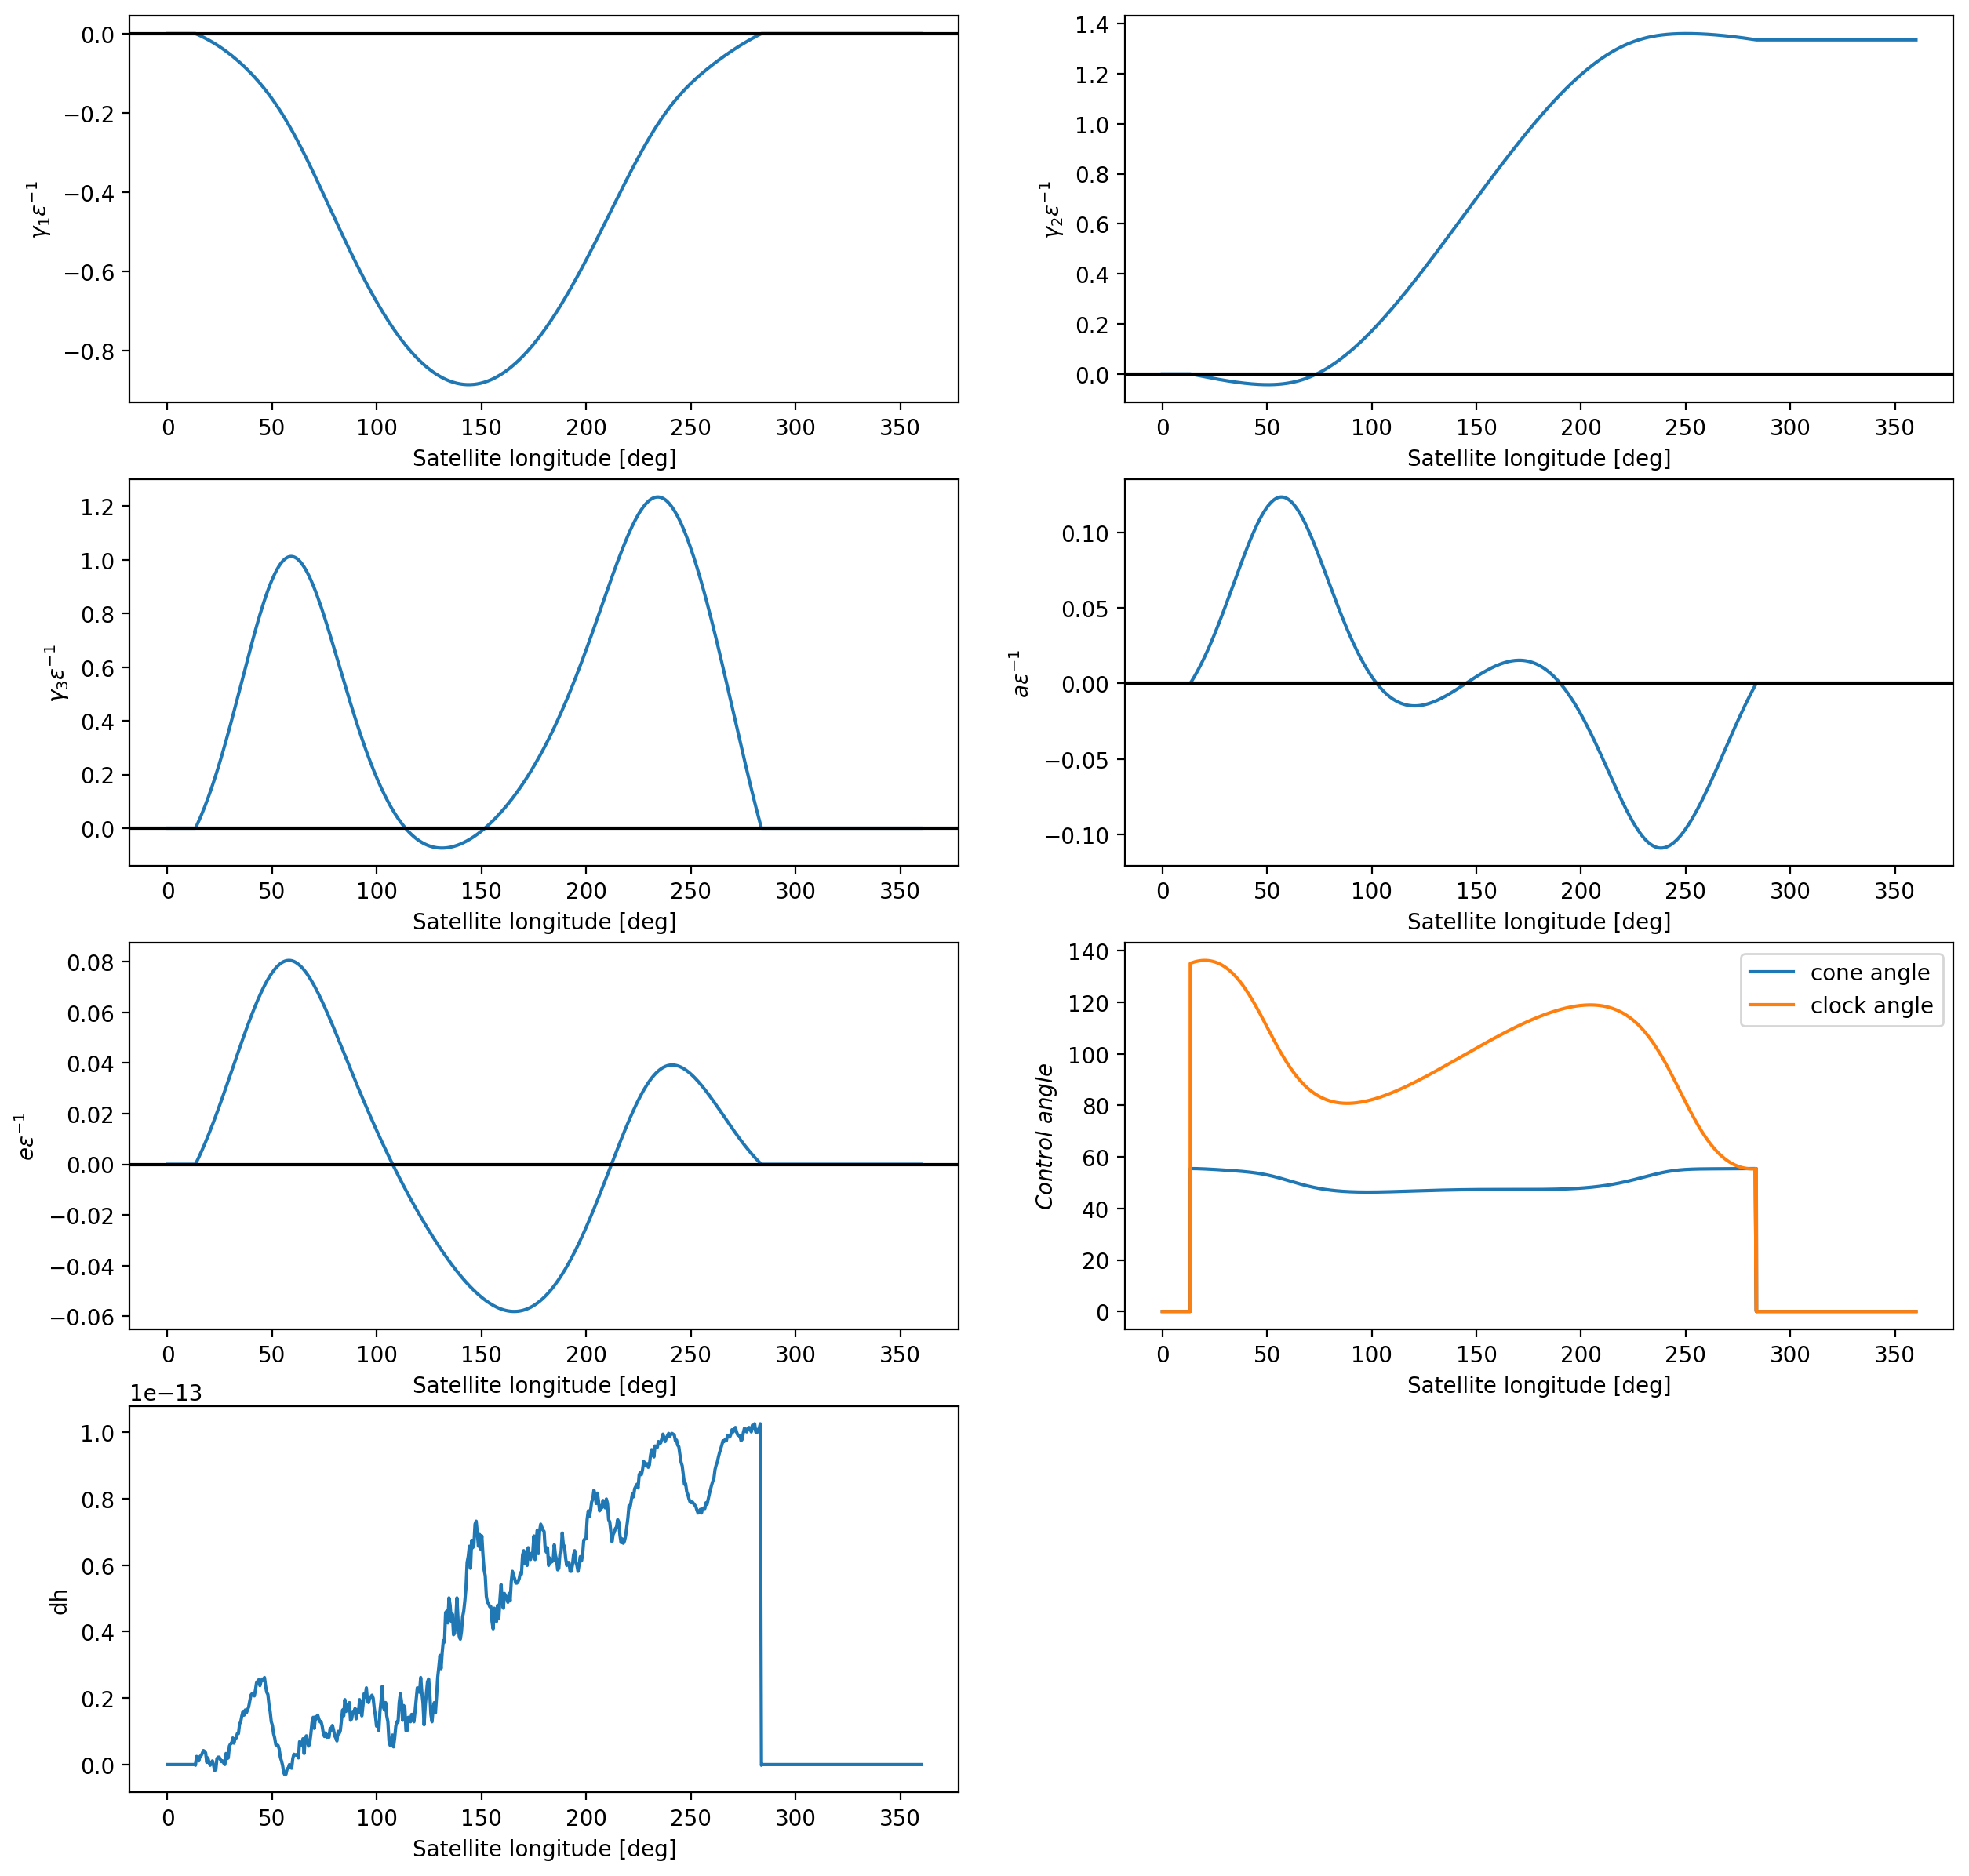

In [20]:
plotSolutionBSB(pdeltaI, M, alpha, sDir, sol.parsf, 1)

### Multiple orbits

/net/home/c/ct705827/.conda/envs/ct-gallery/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in true_divide


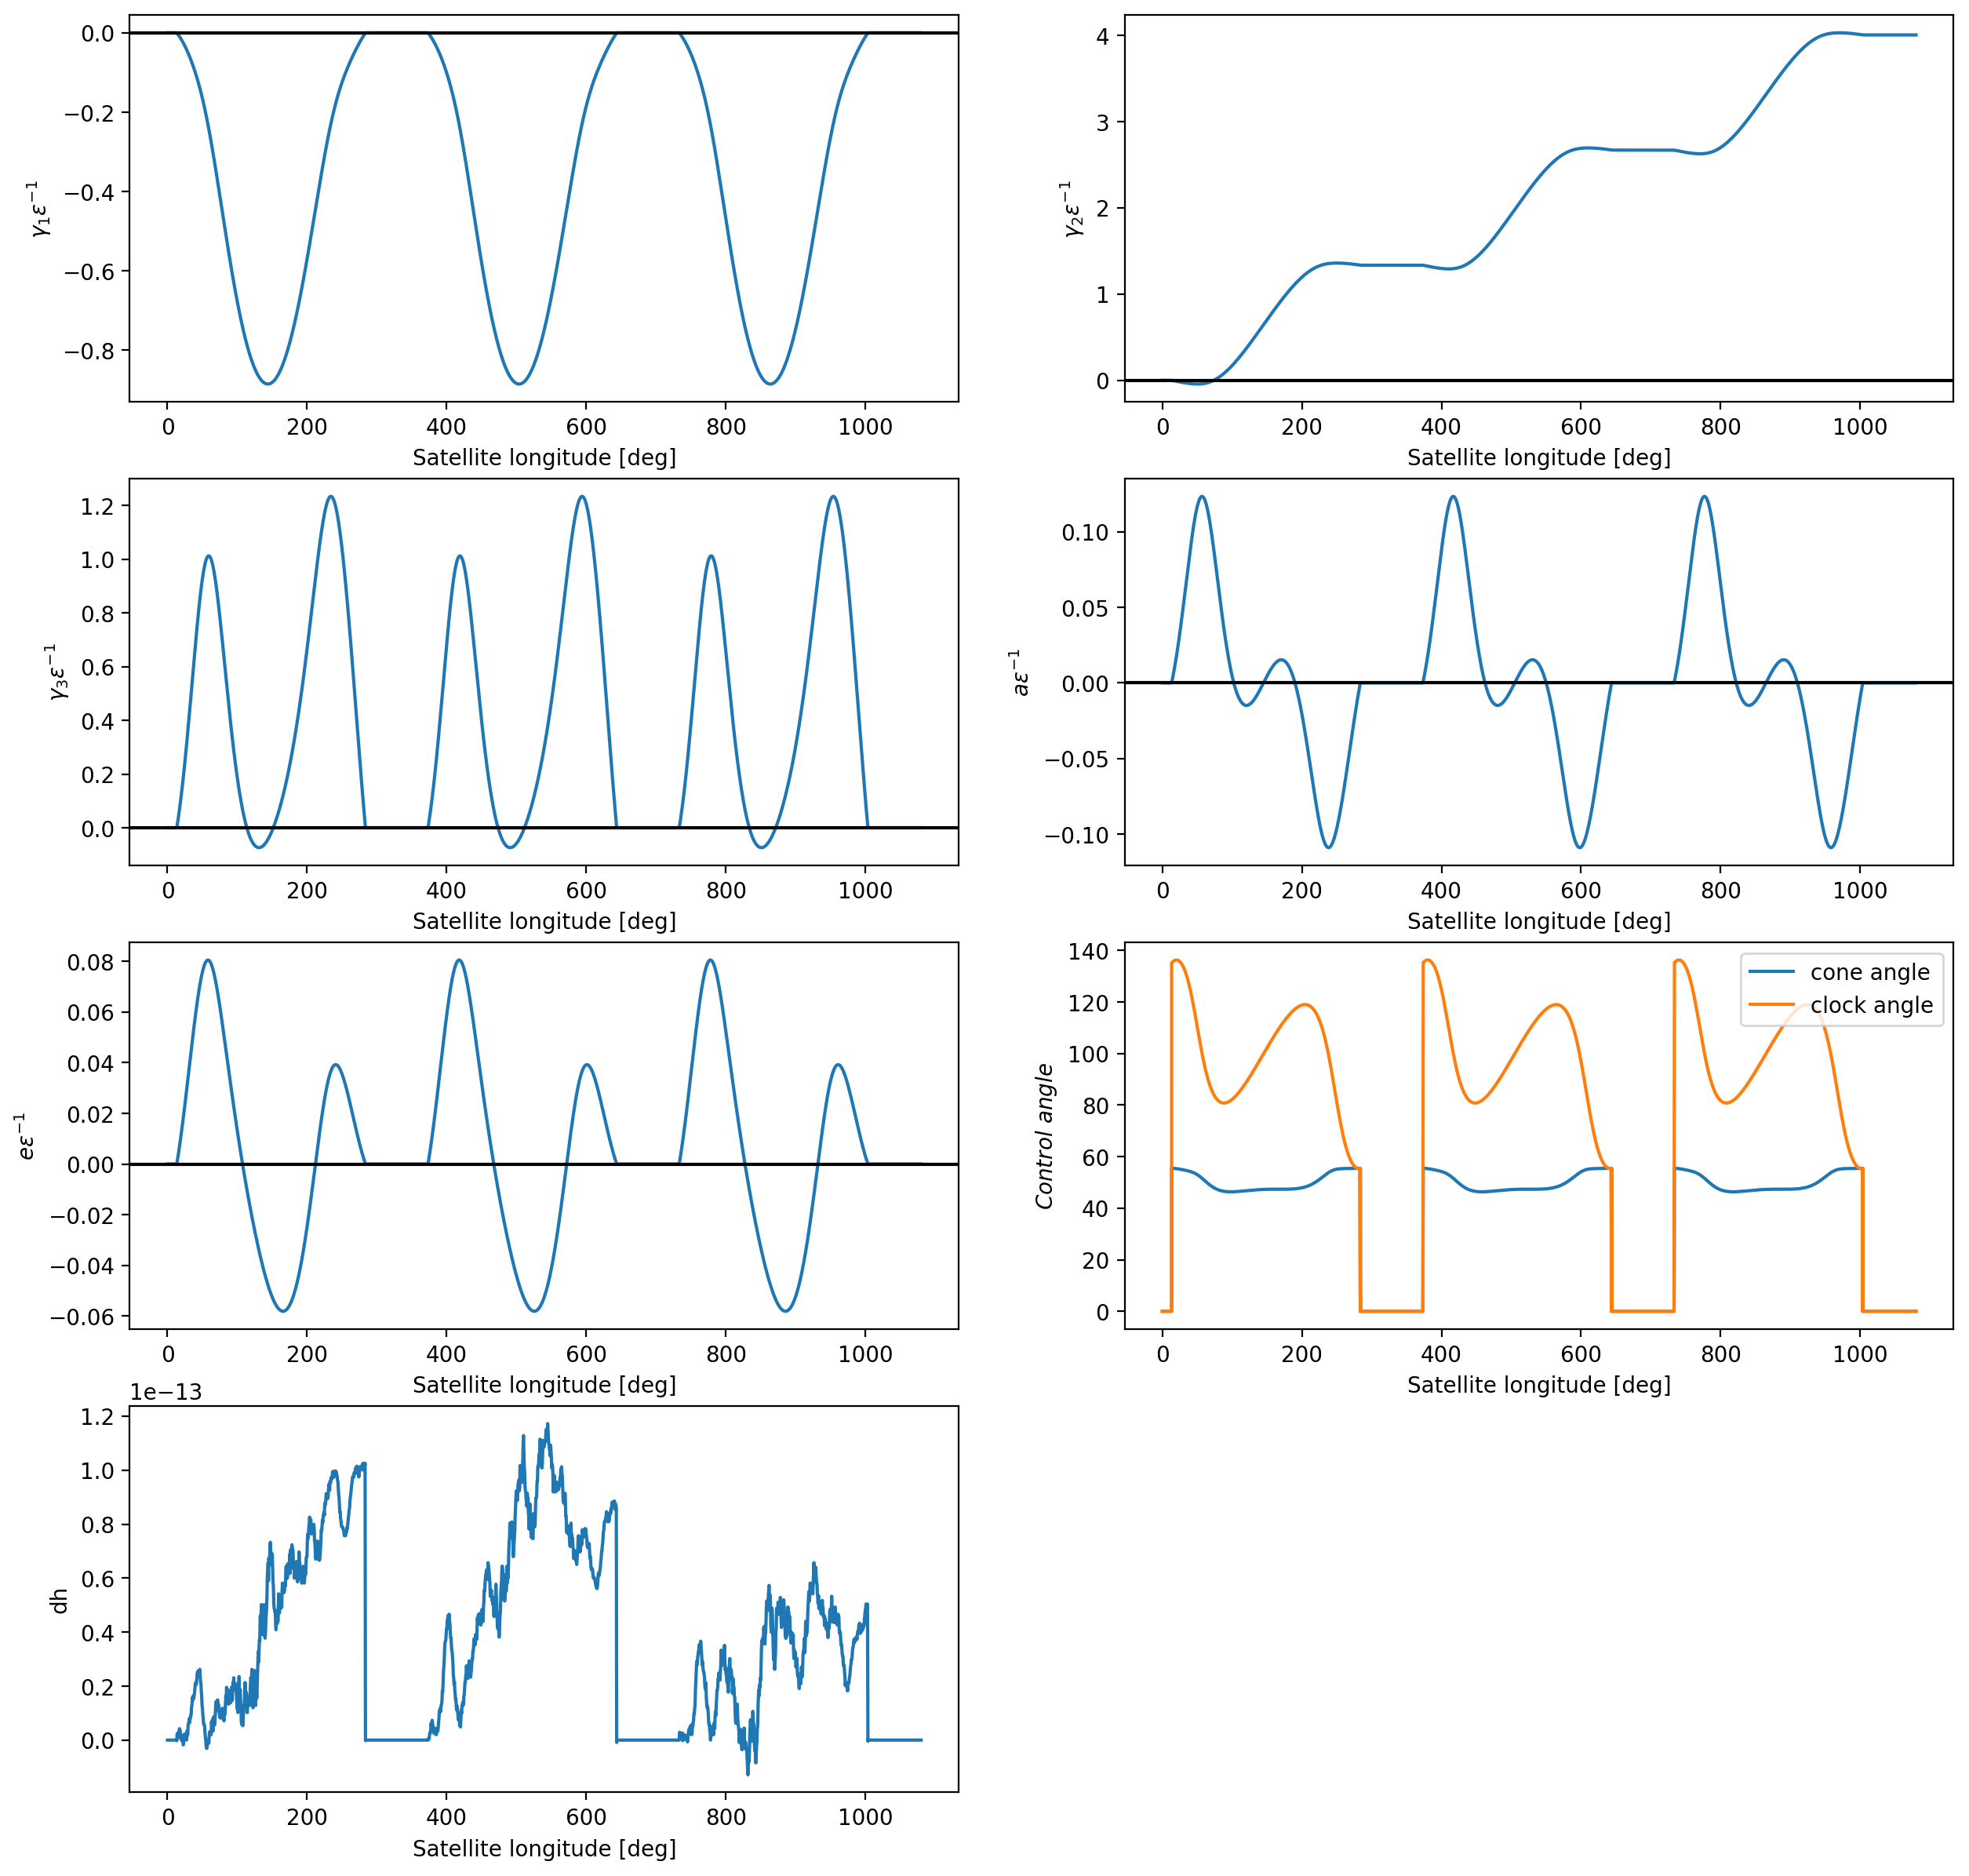

In [21]:
plotSolutionBSB(pdeltaI, M, alpha, sDir, sol.parsf, 3)

In [22]:
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#Initialization of the plot structure
fig = plt.figure(figsize=(4,3)); plt.tight_layout()
line, = plt.plot([], [], linewidth=0.7)
line2, = plt.plot([], [], linewidth=0.7)
plt.xlim(0, 360)
plt.ylim(-100, 200)
plt.xlabel("Satellite longitude", fontsize=5)
plt.ylabel("Control angle", fontsize=5)
plt.legend(["Cone angle","Clock angle"], fontsize = 5)
for tickLabel in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tickLabel.set_fontsize(5)

#Function that animate the gif
def animate(j) :
    M = np.array([])
    alpha = np.array([])
    if(j < len(allfirstsols)) :
        pdeltaI         = allfirstsols[j][0 : 5]
        size = nb_switches1
        M = np.hstack((M, M0))
        for i in range(0, size) :
            M = np.hstack((M, allfirstsols[j][i+5]))
        M = np.hstack((M, Mf))
        
        for i in range(0, np.size(allfirstsols[j]) - ((size + 1) * 5 + size)):
            alpha = np.hstack((alpha, allfirstsols[j][(size + 1) * 5 + size + i]))
            
        [M_vect, ang1, ang2] = plotControl(pdeltaI, M, alpha, sDir, firstpars[j], 1)
    else :
        j = j - len(allfirstsols)
        pdeltaI         = allfinalsols[j][0 : 5]
        size = nb_switches
        M = np.hstack((M, M0))
        for i in range(0, size) :
            M = np.hstack((M, allfinalsols[j][i+5]))
        M = np.hstack((M, Mf))
        
        for i in range(0, np.size(allfinalsols[j]) - ((size + 1) * 5 + size)):
            alpha = np.hstack((alpha, allfinalsols[j][(size + 1) * 5 + size + i]))
            
        [M_vect, ang1, ang2] = plotControl(pdeltaI, M, alpha, sDir, finalpars[j], 1)
        
    line.set_data(M_vect, ang1)
    line2.set_data(M_vect, ang2)
    return line, line2

#Function that plot the control only
def plotControl(pdeltaI, M, alpha, sDir, cont, nOrb):

    N       = 500
    size    = np.size(M) - 2 
    
    M_vect  = np.array([])
    M0_2_Mf = np.array([])
    coneang = np.array([])
    p       = np.array([])

    pTot       = []
    qTot       = []
    
    u_vect     = np.array([0., 0., 0.])
    ddeltaI    = np.array([0., 0., 0., 0., 0.])
    dpdeltaI   = np.array([0., 0., 0., 0., 0.])
    I          = np.array([0., 0., 0., 0., 0]) 
    deltaI0    = np.array([0., 0., 0., 0., 0]) 
            
    M0      = M[0]
    p       = np.hstack((pdeltaI, 0.0))
       
    for i in range(0, size + 1) :
        M0_2_Mf = np.hstack((M0_2_Mf, np.linspace(M[i], M[i+1], N+1)))

    
    #------------------------------------------------------------------
        
    for ii in range(nOrb):
        
        Mspan      = []     
        deltaIsol  = []
        pdeltaIsol = []
        qsol       = []
        psol       = []
        
        for i in range(0, size + 1) : 
            deltaIsol.append(list(np.ones(N+1)))
            pdeltaIsol.append(list(np.ones(N+1)))
            qsol.append(list(np.ones(N+1)))
            psol.append(list(np.ones(N+1)))
            
        compt   = 0
        
        for i in range(0, size + 1) : 
            Mspan.append(list((ii)*2*np.pi*np.ones(N+1)+M0_2_Mf[i*(N+1) : (i+1)*(N+1)]))

        #Calcul of hcone
        pIG = calculpIG(M0, pars[1:6], pdeltaI)
        ucone = pmpcone(pIG, sDir, pars[7:9])
        hcone = np.dot(pIG, ucone)

        if(hcone <= 0) :
            deltaIsol[0], pdeltaIsol[0] = f0(M0, deltaI0, pdeltaI, Mspan[0], pars, cont)
            bool = True
            
        else :
            compt += 1
            
            q0 = np.array([])
            q0 = np.hstack((deltaI0, alpha[0]))
            
            qsol[0], psol[0] = fu(M0, q0, p, Mspan[0], pars, cont)
            
            deltaIsol[0 : 5] = qsol[0 : 5]
            pdeltaIsol[0 : 5] = psol[0 : 5]
            qTot.append(qsol[0])
            pTot.append(psol[0])
            bool = False
    
        for i in range(1, size + 1) :
            if(bool == False) :
                deltaIsol[i], pdeltaIsol[i] = f0(Mspan[i-1][-1], deltaIsol[i-1][-1], pdeltaI, Mspan[i], pars, cont)
                bool = True
                
            else :
                compt += 1
                
                for kk in range(N+1) :
                    qsol[i-1][kk] = np.hstack((deltaIsol[i-1][kk], alpha[compt - 1]))
                    psol[i-1][kk] = np.hstack((pdeltaIsol[i-1][kk], 0.0))
                    qTot.append(qsol[i-1][kk])
                    pTot.append(psol[i-1][kk])
                    
                qsol[i], psol[i] = fu(Mspan[i-1][-1], qsol[i-1][-1], p, Mspan[i], pars, cont)
                
                for kk in range(N+1) :
                    deltaIsol[i][kk] = qsol[i][kk][0:5]
                    pdeltaIsol[i][kk] = psol[i][kk][0:5]
                    qTot.append(qsol[i][kk])
                    pTot.append(psol[i][kk])
                bool = False
                
        if(bool == True) :       
            for kk in range(N+1) :
                qsol[-1][kk] = np.hstack((deltaIsol[-1][kk], alpha[compt - 1]))
                psol[-1][kk] = np.hstack((pdeltaIsol[-1][kk], 0.0))
                qTot.append(qsol[-1][kk])
                pTot.append(psol[-1][kk])
                
        for i in range(0,size + 1) :
            M_vect        = np.hstack((M_vect, Mspan[i]))
        
        for j in range(0, size + 1) :
            for kk in range(N+1): 
                
                if(Hu(Mspan[j][kk], qsol[j][kk], psol[j][kk], pars, cont) < 0) :
                    val           = deltaIsol[j][kk]                          
                    coneang       = np.hstack((coneang, 0.0))
                    
                else :
                    val           = qsol[j][kk]
    
                    #Calcul angle
                    #------------------------------------------------------------------------------
            
                    alpha           = np.hstack((alpha, rad2deg(val[5])))
    
            
                    cAlpha          = np.cos(val[5])
                    sAlpha          = np.sin(val[5])

                    fs              = b[0] * cAlpha + (b[1] * cAlpha**2 + b[2] * cAlpha) * cAlpha
                    fperp           = (b[1] * cAlpha**2 + b[2] * cAlpha) * sAlpha
            
                    coneang         = np.hstack((coneang, rad2deg(np.arctan2(fperp, fs))))
                
                    #-------------------------------------------------------------------------------

        if(hcone <= 0) :
            deltaI0  = deltaIsol[-1][-1]
        else :
            deltaI0  = qsol[-1][-1]
        M0           = Mspan[-1][-1]

    #Calcul of the clock angle
    #----------------------------------------------------------
            
    u_vect = control(M_vect, qTot, pTot, cont)
    u_s    = np.dot(u_vect,sDir)
    u_1    = u_vect[:,0]
    u_2    = u_vect[:,1]
    u_3    = u_vect[:,2]

    norm   = np.linalg.norm(u_vect,axis=1)
    ang2   = np.arctan2(u_2 / norm , u_1 / norm)
    where_are_NaNs = np.isnan(ang2)
    ang2[where_are_NaNs] = 0
    ang2   = rad2deg(ang2)
    M_vect = M_vect / 2 / np.pi * 360
    
    return M_vect, coneang, ang2
    
ani = animation.FuncAnimation(fig, animate, frames=len(allfirstsols)+len(sol.xout), interval=100)

video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

plt.close()

/net/home/c/ct705827/.conda/envs/ct-gallery/lib/python3.7/site-packages/ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in true_divide
